# <center> Сегментация клиентов онлайн магазина подарков

## Постановка задачи

Построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку исходного набора данных о транзакциях.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать набор данных о характеристиках каждого из уникальных клиентов.
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.




## Данные и их описание

Признаки, описывающие каждую транзакцию:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* StockCode — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию;
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing , cluster , metrics, decomposition, mixture
import datetime as dt

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

## Знакомство со структурой данных

In [2]:
data = pd.read_csv(
    "./data/data_pr6.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [3]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print('Date interval {} to {}'.format(data['InvoiceDate'].dt.date.min(), data['InvoiceDate'].dt.date.max()))

Date interval 2010-12-01 to 2011-12-09


In [4]:
print(f'Number of Nan: {data.isnull().sum().sum()}')
print(f'Number of duplicates: {data.duplicated().sum()}')

Number of Nan: 136534
Number of duplicates: 5268


In [5]:
display(data.describe())
display(data.describe(include=object))  # основные диапазоны данных включая категориальные признаки

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


,InvoiceNo,StockCode,Description,CustomerID,Country
count,541909,541909,540455,406829,541909
unique,25900,4070,4223,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17841,United Kingdom
freq,1114,2313,2369,7983,495478


In [6]:
print(f'Countries of sales: {data.Country.unique()}')

Countries of sales: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']


## Преобразование, очистка и анализ данных

In [7]:
data.dropna(axis=0, inplace=True) # удаляем пропуски в строках
data.isna().sum().sum()

0

In [8]:
data.drop_duplicates(inplace=True) # удаляему дубликаты
data.duplicated().sum()

0

In [9]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
...,...,...,...
22185,18283,579673,50
22186,18283,580872,50
22187,18287,554065,29
22188,18287,570715,38


Более 16 % уникальных заказов являются возвратами.

In [10]:
def get_quantity_canceled(data):
    """Функция для создания признака количества отменённых заказов. 
    Функция принимает на вход таблицу и возвращает столбец, в котором указано количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента, данный признак помечается как NaN.

    Args:
        data (DataFrame): таблица с транзакциями

    Returns:
        Series: столбец с количеством отменённого товара
    """
    # Инициализируем нулями Series той же длины, что и столбцы таблицы.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента — ничего не делаем
        if (df_test.shape[0] == 0): 
            # Помечаем столбец как пропуск
            quantity_canceled.loc[index] = np.nan
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отменённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаём количество отменённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара больше количества товаров в транзакции-возврате.
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

In [11]:
df = data.copy()

In [12]:
print(df['QuantityCanceled'].isna().sum())
df.dropna(inplace=True) # удалим все транзакции с отсутствующими контрагентами
df.info()

1303
<class 'pandas.core.frame.DataFrame'>
Int64Index: 400301 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         400301 non-null  object        
 1   StockCode         400301 non-null  object        
 2   Description       400301 non-null  object        
 3   Quantity          400301 non-null  int64         
 4   InvoiceDate       400301 non-null  datetime64[ns]
 5   UnitPrice         400301 non-null  float64       
 6   CustomerID        400301 non-null  object        
 7   Country           400301 non-null  object        
 8   QuantityCanceled  400301 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 30.5+ MB


In [13]:
df.drop(df[df.Quantity < 0].index, inplace=True) # так же удалим транзакции с отрицательным количеством товара

In [14]:
scode_todrop = df[df.StockCode.str.match('^[a-zA-Z]+') == True].index # выделим индексы всех специальных транзакций и удалим
df.drop(index=scode_todrop, axis=0, inplace=True)

In [15]:
df.drop(index=df[df.UnitPrice == 0].index, inplace=True) # удалим товары с нулевой ценой

In [16]:
df['TotalPrice'] = df.UnitPrice * (df.Quantity - df.QuantityCanceled)
df.sort_values(by='Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
465491,576236,84030E,ENGLISH ROSE HOT WATER BOTTLE,1,2011-11-14 13:31:00,4.25,13755,United Kingdom,0.0,4.25
458550,575843,21239,PINK POLKADOT CUP,1,2011-11-11 12:02:00,0.85,14446,United Kingdom,0.0,0.85
458551,575843,72817,SET OF 2 CHRISTMAS DECOUPAGE CANDLE,1,2011-11-11 12:02:00,0.79,14446,United Kingdom,0.0,0.79
458552,575843,23229,VINTAGE DONKEY TAIL GAME,1,2011-11-11 12:02:00,3.75,14446,United Kingdom,0.0,3.75
244896,558558,23236,DOILEY STORAGE TIN,1,2011-06-30 13:17:00,2.89,17841,United Kingdom,0.0,2.89
...,...,...,...,...,...,...,...,...,...,...
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087,United Kingdom,0.0,3202.92
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135,United Kingdom,0.0,3096.00
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901,United Kingdom,0.0,1008.00
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215.0,0.00


### Разведывательный анализ

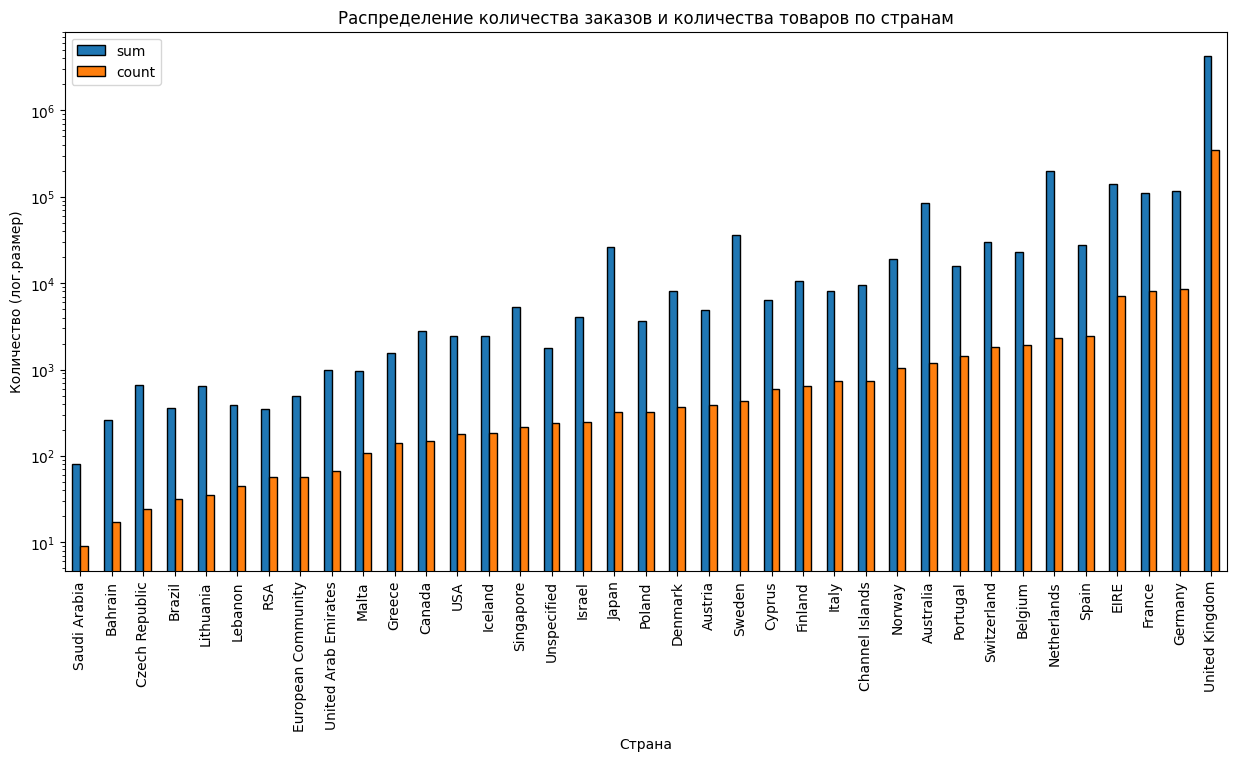

In [17]:
country_grouped = df.groupby(by='Country')['Quantity'].agg(['sum','count']).sort_values(by=['count','sum'])
plot = country_grouped.plot(kind='bar', figsize=(15,7), logy=True)
plt.title('Распределение количества заказов и количества товаров по странам')
plt.xlabel('Страна')
plt.ylabel('Количество (лог.размер)');

Из графика 'Распределение количества заказов и количества товаров по странам' можно увидеть преобладание количества заказов в Великобритании , так как компания базируется как раз там, а так как страна бывший член евросоюза , то следующими по количеству заказов идут как раз страны ЕС.

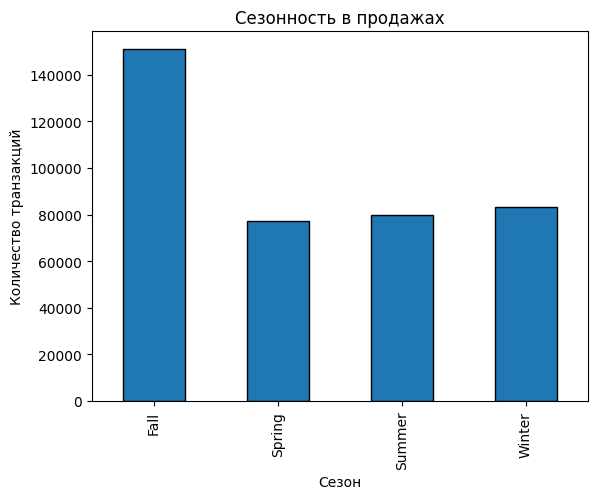

In [18]:
def season(data):                    
    if data.month in [12,1,2]:
        data = 'Winter'
    elif data.month in [3,4,5]:
        data = 'Spring'
    elif data.month in [6,7,8]:
        data = 'Summer'
    else :
        data = 'Fall'
    return data    # функция выделения сезона из даты

df['Season'] = df['InvoiceDate'].apply(season)
df.groupby(by='Season')['InvoiceNo'].count().plot(kind='bar')
plt.title('Сезонность в продажах')
plt.xlabel('Сезон')
plt.ylabel('Количество транзакций');

При группировке данных по сезонам очевидно выделяется осень , количество заказов почти вдвое больше чем в другие сезоны.

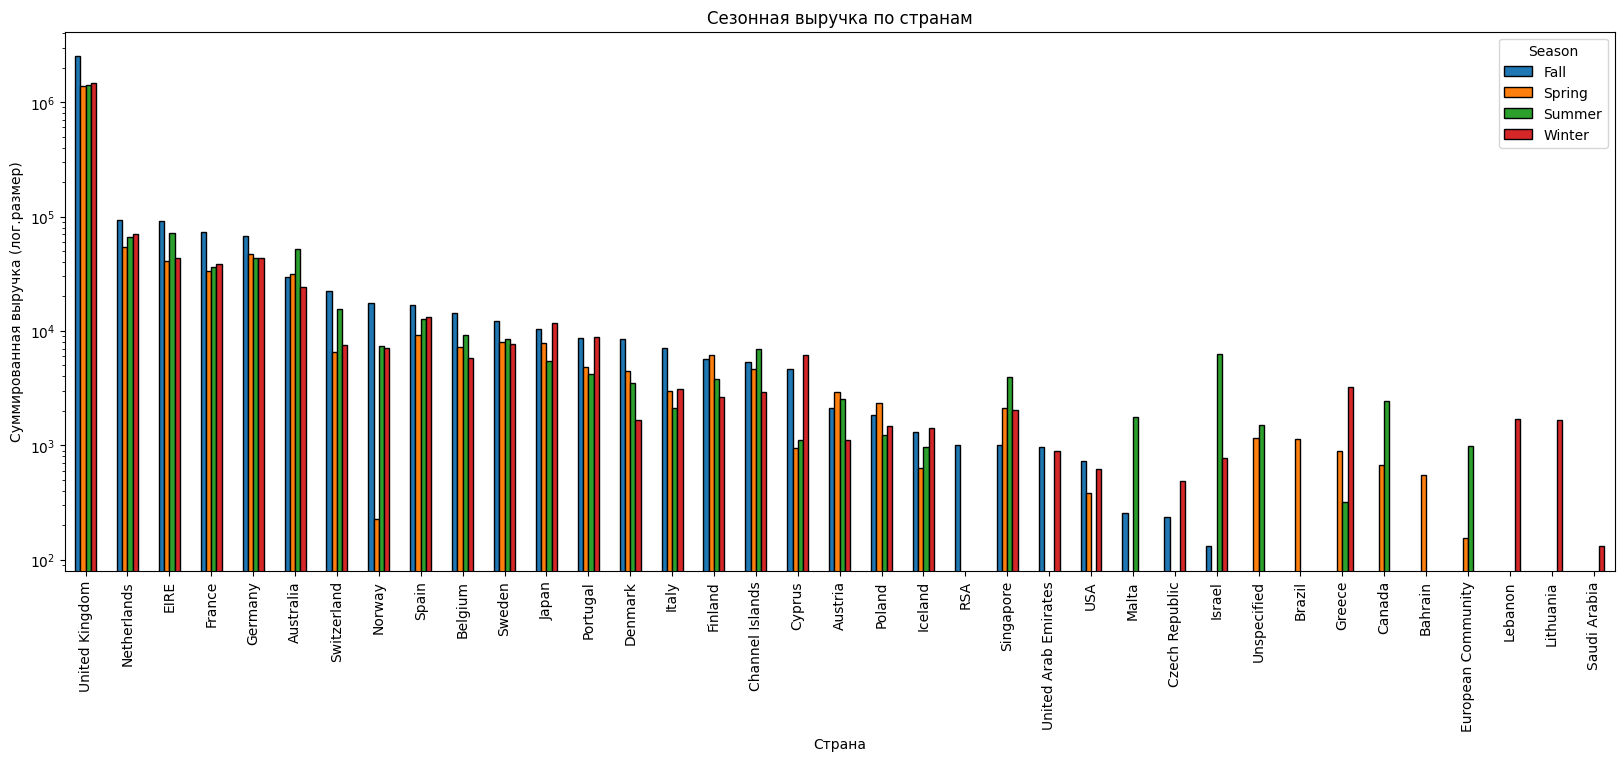

In [19]:
# создадим сводную таблицу для сумарной выручки по сезонам от всех стран
pivot = pd.pivot_table(df,
                       index='Country',
                       columns='Season',
                       values='TotalPrice',
                       aggfunc='sum').sort_values(by=['Fall', 'Spring','Summer', 'Winter'], ascending=False)

pivot.plot(kind='bar', figsize=(20,7), logy=True)
plt.ylabel('Суммированная выручка (лог.размер)')
plt.xlabel('Страна')
plt.title('Сезонная выручка по странам');

При разделении на страны также можно увидеть, что первая пятерка стран по выручке , делает её в основном осенью. Так как компания занимается продажей уникальных подарков на все случаи жизни , то очевидно что как раз под новый год ,самый популярный праздник, почти каждый человек заказывает подарки свои близким. И на данном графике Австралия только подтверждает данное предположение, потому что новый год в странах за экватором празднуют летом, на что указывает подовляющее число заказов в этот сезон.

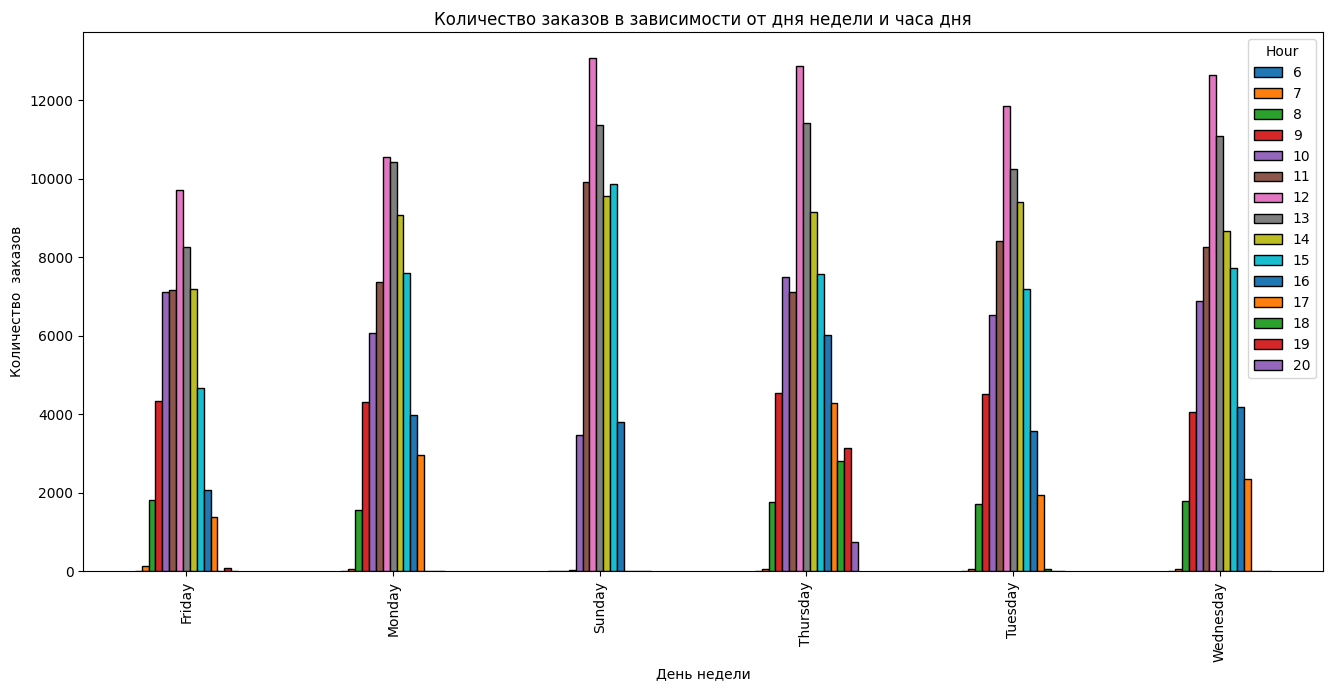

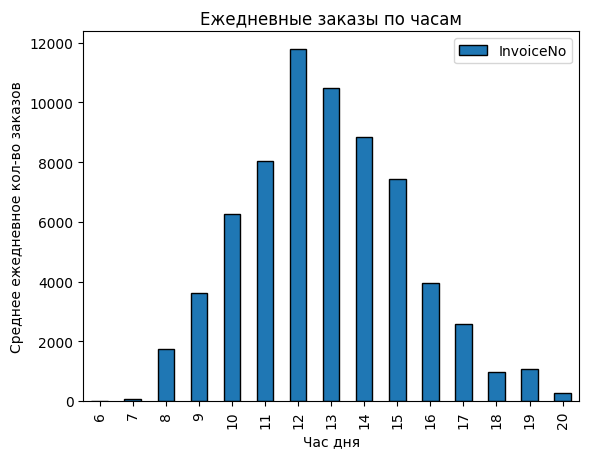

In [20]:
df['Day'] = df.InvoiceDate.dt.day_name()
df['Month'] = df.InvoiceDate.dt.month_name()
df['Hour'] = df.InvoiceDate.dt.hour

pivot_dayhour = pd.pivot_table(data=df, index=df['Day'], columns=df['Hour'], values='InvoiceNo', aggfunc='count', fill_value=0)
pivot_dayhour.plot(kind='bar',figsize=(16,7))
plt.xlabel('День недели')
plt.ylabel('Количество  заказов')
plt.title('Количество заказов в зависимости от дня недели и часа дня');

df.groupby(by=['Day','Hour'], as_index=False)['InvoiceNo'].count().groupby('Hour').mean().plot(kind='bar')
plt.xlabel('Час дня')
plt.ylabel('Среднее ежедневное кол-во заказов')
plt.title('Ежедневные заказы по часам');

Исходя из группированных данных и графиков , можно выделить несколько особенностей, например по субботам не найдено ни одного заказа, возможно это связано с обработкой созданных за неделю заказов, либо приемкой товара. Так же можно выделить что время заказов находится в диапазоне с 6 до 21 часа, можно предположить что это связано с работой сотрудников колл-центра , которые занимаются потверждением заказов , на что так же указывает и время заказов большинство приходится на середину дня когда многие люди бодрствуют.

### Построение RFM-таблицы 

In [320]:
now = dt.datetime(2011,12,10)
rfm_table = df.groupby(by='CustomerID').agg({'InvoiceDate' : lambda x: now - x.max(),
                                             'InvoiceNo' : lambda x: len(x.unique()),
                                             'TotalPrice' : lambda x: x.sum()})
rfm_table.rename(columns = {'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalPrice':'Monetary'}, inplace = True )
rfm_table.Recency = rfm_table.Recency.dt.days
rfm_table

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40
...,...,...,...
18280,277,1,180.60
18281,180,1,80.82
18282,7,2,176.60


In [321]:
# посмотрим сколько в среднем заказов делает клиент за представленный годовой период
print(rfm_table.Frequency.mean().__round__(2))

# так же найдем клиентов которые совершали заказ более полугода назад 
print(rfm_table[rfm_table.Recency > 180]['Recency'].count())

4.25
860


In [322]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_1.html')
fig.show()

Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [323]:
rfm_table_cleaned = rfm_table[(rfm_table.Frequency <= rfm_table.Frequency.quantile(0.95)) & (rfm_table.Monetary <= rfm_table.Monetary.quantile(0.95))]
rfm_table_cleaned

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40
...,...,...,...
18278,73,1,173.90
18280,277,1,180.60
18281,180,1,80.82


In [324]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_2.html')
fig.show()

Построим визуализацию трёхмерного пространства признаков:

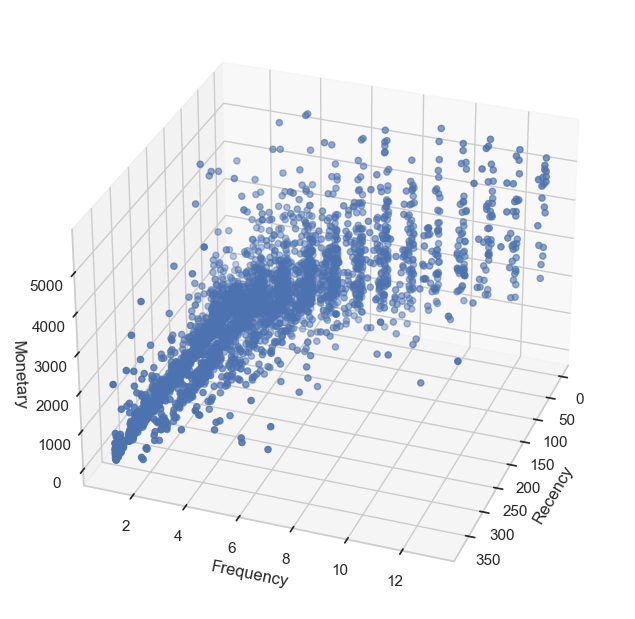

In [325]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


Видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

## Моделирование и оценка качества моделей

# PCA

In [326]:
from sklearn.pipeline import Pipeline
# создадим pipeline со стандартизацией и понижения расмерности метоодом РСА с 2 компонентами 
pipe_rfm = Pipeline(steps=[('scaler', preprocessing.StandardScaler()), ('PCA', decomposition.PCA(n_components=2))])
pipe_rfm.fit(rfm_table_cleaned)
rfm_table_processed = pipe_rfm.transform(rfm_table_cleaned)
print('Дисперсия первой главной компоненты = {}'.format(round(pipe_rfm['PCA'].explained_variance_ratio_[0],2))) 

Дисперсия первой главной компоненты = 0.68


# K-means

0.524


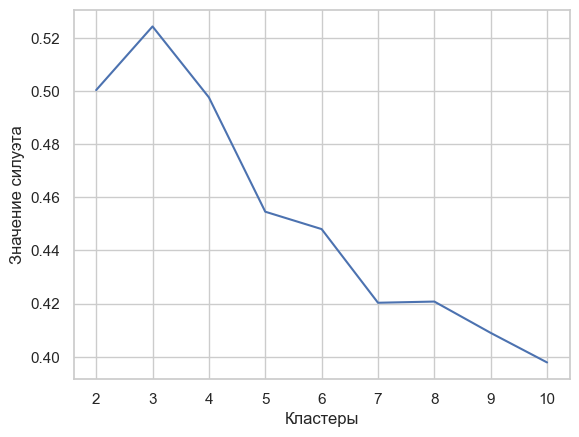

In [327]:
def get_sihouette(data, n_clusters):
    kmean = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    kmean.fit(data)
    silhoette = metrics.silhouette_score(data, kmean.labels_)
    return silhoette

silh_score = []
for i in range(2,11):
    silh_score.append(get_sihouette(rfm_table_processed, i))
    
print(round(np.max(silh_score),3))

plt.plot([i for i in range(2,11)], silh_score)
plt.xlabel('Кластеры')
plt.ylabel('Значение силуэта');

# EM

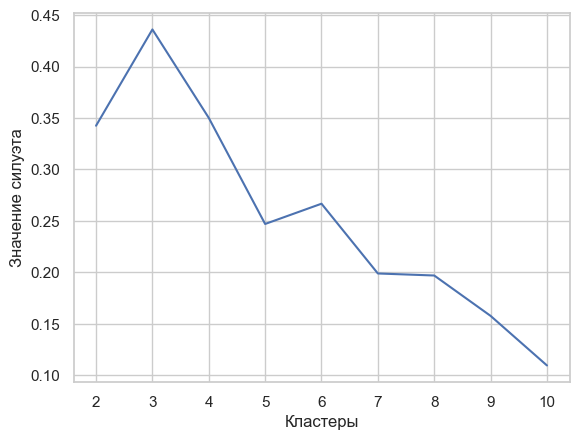

In [328]:
def get_sihouette(data, n_components):
    em = mixture.GaussianMixture(n_components=n_components, random_state=42)
    em.fit(data)
    silhoette = metrics.silhouette_score(data, em.predict(data))
    return silhoette

silh_score = []
for i in range(2,11):
    silh_score.append(get_sihouette(rfm_table_processed, i))
    
plt.plot([i for i in range(2,11)], silh_score)
plt.xlabel('Кластеры')
plt.ylabel('Значение силуэта');

# AgglomerativeClustering

0.523


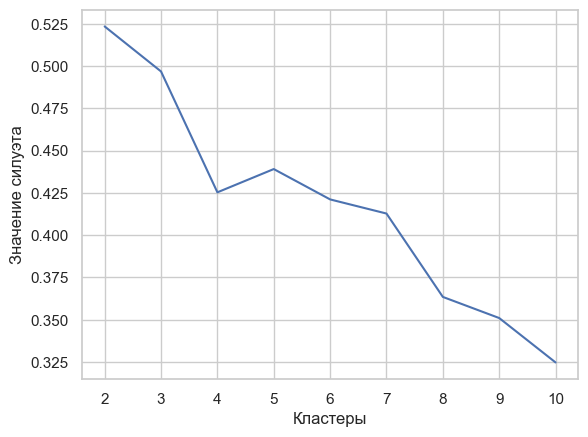

In [329]:
def get_sihouette(data, n_clusters):
    agglo = cluster.AgglomerativeClustering(n_clusters=n_clusters)
    agglo.fit(data)
    silhoette = metrics.silhouette_score(data, agglo.labels_)
    return silhoette

silh_score = []
for i in range(2,11):
    silh_score.append(get_sihouette(rfm_table_processed, i))
    
print(round(np.max(silh_score),3))

plt.plot([i for i in range(2,11)], silh_score)
plt.xlabel('Кластеры')
plt.ylabel('Значение силуэта');

Проведя кластеризацию разными методами, получаем лучшее значение коэффицента силуэта у алгоритма Kmeans при 3 кластерах.

Сделам предсказание меток класса на оптимальном количестве кластеров

In [330]:
kmeans = cluster.KMeans(n_clusters=3, random_state=42)
kmeans.fit(rfm_table_processed)
rfm_table_cleaned['Label'] = kmeans.labels_
rfm_table_cleaned

,Recency,Frequency,Monetary,Label
CustomerID,,,,
12346,325,1,0.00,0
12347,2,7,4310.00,1
12348,75,4,1437.24,2
12349,18,1,1457.55,2
12350,310,1,294.40,0
...,...,...,...,...
18278,73,1,173.90,2
18280,277,1,180.60,0
18281,180,1,80.82,0


### Интерпретация результатов кластеризации

In [331]:
fig = px.scatter_3d(
    data_frame=rfm_table_cleaned,
    x='Recency',
    y = 'Frequency', 
    z = 'Monetary', 
    color='Label', 
    width=1000,
    height=1000
)
fig.update_traces(marker_size = 4) 
fig.show()
fig.write_html("plotly/scatter_3d_RFM.html")

Исходя из полученных данных , мы имеем 3 сегмента клиентов , к 1 кластеру относятся клиенты самые интересные для магазина , так как у них и стоимость чека и частота покупок наибольшая из представленных покупателей, в тоже время у варемя последнего заказа у большинства . К 2 кластеру относятся "среднечки" - покупают со стабильной частотой и регулярностью, но в основном не самые дорогие товары. Ко 0 же кластеру относяться клиенты которые зазказывали в основном более полугода назад недорогие и единичные товары. 

In [332]:
def plot_cluster_profile(grouped_data, n_clusters):
    """Функция для визуализации профиля кластеров в виде полярной диаграммы.

    Args:
        grouped_data (DataFrame): таблица, сгруппированная по номерам кластеров с агрегированными характеристиками объектов.
        n_clusters (int): количество кластеров
    """
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаём список признаков
    features = grouped_data.columns
    # Создаём пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название — номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()

In [334]:
grouped_rfm = rfm_table_cleaned.groupby('Label').mean()

plot_cluster_profile(grouped_rfm, 3)
fig.write_html("plotly/scatterpolar_RFM.html")

Полярная диаграмма очень хорошо показывает клиентов которые более интересны для бизнеса , а именно клиенты из 2 и 1 кластера.

## Выводы 

В ходе проделанной работы : 
* проанализированы данные 
* найдены и очищенны дубликаты и пустые значения
* созданы новые признаки 
* создана RFM таблица
* снижена размерность для удобства интерпретации 
* произведена кластеризация клиентов с помощью нескольких алгоритмов

В результате исследования было выявленно 3 сегмента клиентов:
* "Лояльные",  которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки небольшая.
* "Промежуточные" , которые являются активными, но покупают не так часто и много, как лояльные клиенты. 
* "Ушедшие", которые купили меньше всего товара, и их последняя покупка была совершена очень давно.
